# _(Mi, et. al., 2017)_ STP for Working Memory Capacity

Implementation of the paper:

- Mi, Yuanyuan, Mikhail Katkov, and Misha Tsodyks. "Synaptic correlates of working memory capacity." Neuron 93.2 (2017): 323-330.

In [1]:
import numpy as np
import brainpy as bp

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
dt = 0.0001  # [s]
bp.backend.set(dt=dt)

In [3]:
alpha = 1.5
J_EE = 8.  # the connection strength in each excitatory neural clusters
J_IE = 1.75  # Synaptic efficacy E → I
J_EI = 1.1  # Synaptic efficacy I → E
tau_f = 1.5  # time constant of STF  [s]
tau_d = .3  # time constant of STD  [s]
U = 0.3  # minimum STF value
tau = 0.008  # time constant of firing rate of the excitatory neurons [s]
tau_I = tau  # time constant of firing rate of the inhibitory neurons

Ib = 8.  # background input and external input
Iinh = 0.  # the background input of inhibtory neuron

cluster_num = 16  # the number of the clusters

In [4]:
# the parameters of external input

stimulus_num = 5
Iext_train = 225  # the strength of the external input
Ts_interval = 0.070  # the time interval between the consequent external input [s]
Ts_duration = 0.030  # the time duration of the external input [s]
duration = 2.500  # [s]

In [5]:
# the excitatory cluster model and the inhibitory pool model

class WorkingMemoryModel(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    def __init__(self, size, **kwargs):
        self.inh_h = 0.
        self.inh_r = self.log(self.inh_h)
        self.u = bp.backend.ones(cluster_num) * U
        self.x = bp.backend.ones(cluster_num)
        self.h = bp.backend.zeros(cluster_num)
        self.r = self.log(self.h)
        self.input = bp.backend.zeros(cluster_num)
        
        super(WorkingMemoryModel, self).__init__(size, **kwargs)
    
    @staticmethod
    @bp.odeint
    def int_exc(u, x, h, t, r, r_inh, Iext):
        du = (U - u) / tau_f + U * (1 - u) * r
        dx = (1 - x) / tau_d - u * x * r
        dh = (-h + J_EE * u * x * r - J_EI * r_inh + Iext + Ib) / tau
        return du, dx, dh
    
    @staticmethod
    @bp.odeint
    def int_inh(h, t, r_exc):
        return (-h + J_IE * np.sum(r_exc) + Iinh) / tau_I

    @staticmethod
    def log(h):
        return alpha * np.log(1. + np.exp(h / alpha))

    def update(self, _t):
        self.u, self.x, self.h = self.int_exc(self.u, self.x, self.h, _t, self.r, self.inh_r, self.input)
        self.r = self.log(self.h)
        self.inh_h = self.int_inh(self.inh_h, _t, self.r)
        self.inh_r = self.log(self.inh_h)
        self.input[:] = 0.

In [6]:
# the external input

I_inputs = np.zeros((int(duration / dt), cluster_num))
for i in range(stimulus_num):
    t_start = (Ts_interval + Ts_duration) * i + Ts_interval
    t_end = t_start + Ts_duration
    idx_start, idx_end = int(t_start / dt), int(t_end / dt)
    I_inputs[idx_start: idx_end, i] = Iext_train

In [7]:
# model.monwork running

model = WorkingMemoryModel(cluster_num, monitors=['u', 'x', 'r', 'h'])
model.run(duration, inputs=['input', I_inputs])

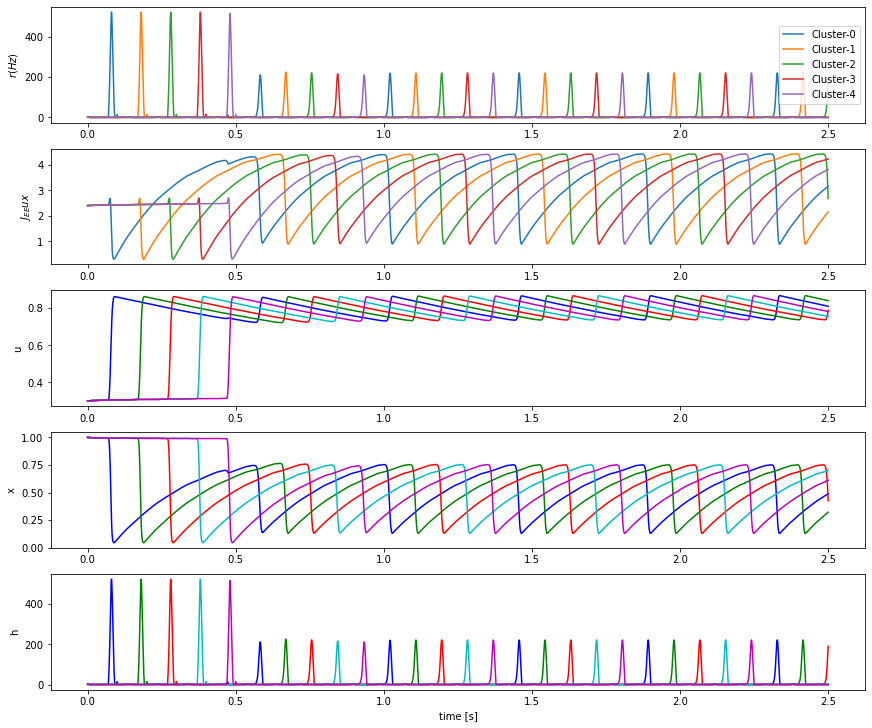

In [8]:
# visualization

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

fig, gs = bp.visualize.get_figure(5, 1, 2, 12)
fig.add_subplot(gs[0, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.r[:, i], label='Cluster-{}'.format(i))
plt.ylabel("$r (Hz)$")
plt.legend(loc='right')

fig.add_subplot(gs[1, 0])
hist_Jux = J_EE * model.mon.u * model.mon.x
for i in range(stimulus_num):
    plt.plot(model.mon.ts, hist_Jux[:, i])
plt.ylabel("$J_{EE}ux$")

fig.add_subplot(gs[2, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.u[:, i], colors[i])
plt.ylabel('u')

fig.add_subplot(gs[3, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.x[:, i], colors[i])
plt.ylabel('x')

fig.add_subplot(gs[4, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.r[:, i], colors[i])
plt.ylabel('h')
plt.xlabel('time [s]')

plt.show()